In [45]:
def hgb_hist(df):
    hgb_min=np.floor(min(df.Hgb))
    hgb_max=np.ceil(max(df.Hgb))
    bins=np.arange(hgb_min, hgb_max+1, 1)
    count, _ = np.histogram(df["Hgb"], bins=bins)

    fig, ax = plt.subplots(1, 1)
    ax.hist(df["Hgb"], bins=bins, edgecolor='white')

    # ax.grid()
    ax.set_title("Sample Distribution", fontsize=18)
    ax.set_xlabel("Hgb Levels (g/dL)", fontsize=16)
    ax.set_ylabel("Counts", fontsize=16)
    ax.set_xticks(bins)
    ax.set_xticklabels(bins)

    rects = ax.patches
    labels = ["%d" % count[i] for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
                ha='center', va='bottom')

In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, pyrebase, cv2, rawpy, imageio, datetime, json
from scipy.stats import ttest_ind

(37, 7)


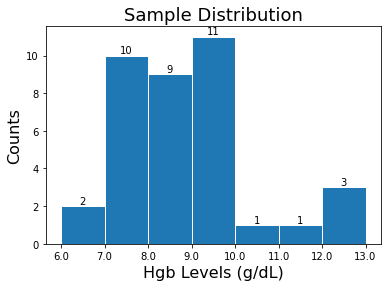

In [380]:
df = pd.read_excel("./Participants_table_2021-11-15.xlsx")
# df = df[(df.Hgb<12) & (df.Hgb>=8)]
df_diagnosed = df.dropna(subset=["Hgb", "Diagnosis"])
print(df[df.patient_number.str.startswith('H', na=False)].shape)
hgb_hist(df[df.patient_number.str.startswith('H', na=False)])
# df_no_diag = df[~df.index.isin(df_diagnosed.index)] #.sample(n=df_no_diag.shape[0], random_state=1)
# df_no_diag_7_9 = df_no_diag[df_no_diag.Hgb<=10] #.sample(n=df_no_diag.shape[0], random_state=1)
# df_no_diag_9_12 = df_no_diag[df_no_diag.Hgb>10].sample(n=(2+df_diagnosed.shape[0]-df_no_diag_7_9.shape[0]), random_state=1)
# df_no_diag = pd.concat([df_no_diag_7_9, df_no_diag_9_12])
# print(df_diagnosed.shape, df_no_diag.shape)

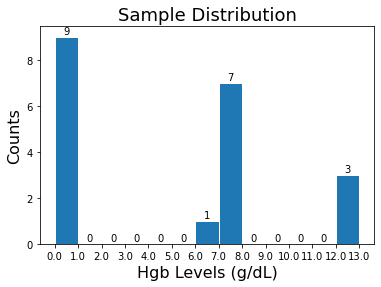

In [375]:
df = pd.read_excel("./Participants_table_2021-11-15.xlsx")
df_H= df[df.patient_number.str.startswith('H', na=False)]
hgb_hist(df_H[~df_H.patient_number.isin(df_diagnosed.patient_number)])

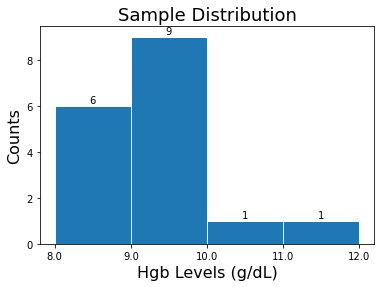

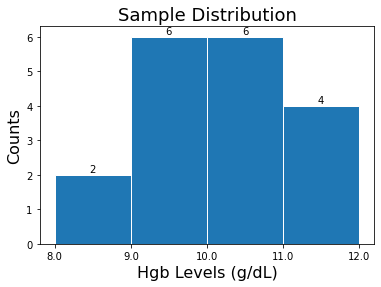

In [158]:
hgb_hist(df_diagnosed)
hgb_hist(df_no_diag)

In [300]:
def get_poly_from_1_image(img_path, shape, dim):
    img = cv2.imread(img_path).astype(np.float32)
    img= img/255
    color = (1, 0, 0)
    thickness = 4
    points= np.array(shape['points'], dtype=np.int32)
    xmin= min(points[0][0],points[1][0])
    xmax= max(points[0][0],points[1][0])
    ymin= min(points[0][1],points[1][1])
    ymax= max(points[0][1],points[1][1])
    label=shape["label"]

    temp_img= img[ ymin: ymax, xmin:xmax, :]
    temp_img= cv2.resize(temp_img, dim, interpolation = cv2.INTER_AREA)

    return temp_img, label

def df_to_imgae(df_source, main_folder= "/home/michal/MYOR Dropbox/Michal Ashkenazi/MYOR_1/Heavy_Files/MyHemoPatientData", dim=(8,8)):
    df_source= df_source.sort_values(by=['Hgb'])
#     print(df_source)
    df_source= df_source.reset_index(drop=True)

    folders_list = os.listdir(main_folder)
    X_data_img=[]
    x_data_ave_values=[]
    
    df= pd.DataFrame()
    for idx, row in df_source.iterrows():
        folder= row["patient_folder"]
        json_path = str(glob.glob(f"{main_folder}/{folder}/*.json"))[2:-2]
        if len(json_path)>0:
            file_name=os.path.splitext(os.path.split(json_path)[1])[0]
            image_path=f'{main_folder}/{folder}/{file_name}.bmp'
            with open(json_path) as handle:
                shape_dicts=json.load(handle)
            if "version" in shape_dicts:
                shape_dicts = shape_dicts["shapes"]
            nails = []
            for ind, shape in enumerate(shape_dicts):
                cutted_img, label=get_poly_from_1_image(image_path,shape,dim)
                if ind <5:
                    nails.append(cutted_img)
            if len(nails)!=5:
                print("Error in number of annotations at",folder)
            df = df.append(row, ignore_index=True)
            X_data_img.append(np.asarray(nails))
        else:
            print("had no json", folder)
    X_data_images=np.array(X_data_img)
    return X_data_images, df

In [307]:
X_data_images_diag, df_diagnosed = df_to_imgae(df_diagnosed)
X_data_images_diag.shape

(17, 5, 8, 8, 3)

In [309]:
X_data_images_no_diag, df_non_diag = df_to_imgae(df_no_diag)
X_data_images_no_diag.shape

had no json 495_0.8_male
had no json 532_9_male


(17, 5, 8, 8, 3)

In [335]:
def methods(x_image_data, concat = False):
#     df=df.reset_index(drop = True)
    d1, d2, d3, d4, d5 = x_image_data.shape
    x_data_reshaped = x_image_data.reshape((d1*d2*d3*d4, d5))
#     standarized_data = StandardScaler().fit_transform(x_data_reshaped)

#     model = TSNE(n_components=1, random_state=0, perplexity=50, n_iter=300)

    l_mean= np.zeros([d1,d2-1])
    l_max= np.zeros([d1,d2-1])
    r_mean= np.zeros([d1,d2-1])
    r_max= np.zeros([d1,d2-1])
    
    for sample_index in range(d1):
        for nail in range(d2-1):  #do not take skin sample
            img= x_image_data[sample_index,nail]
            l_temp=cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,0]
            l_mean[sample_index,nail] = l_temp.mean()
            l_max[sample_index,nail] = l_temp.max()
            red_temp = img[:,:,2]
            r_mean[sample_index,nail] = red_temp.mean()
            r_max[sample_index,nail] = red_temp.max()
    
    return [l_mean, l_max, r_mean, r_max]
            
    
def plot_methods(output_1, output_2, df_1, df_2):
    fig, axs = plt.subplots(4, 2, figsize=(12, 20))
    
    for i_df, [outputs, df] in enumerate([[output_1, df_1], [output_2, df_2]]):
        l_mean, l_max, r_mean, r_max = outputs
        methods_names= ["L Mean", "L Max", "R Mean", "R Max"]
#         for method, name in zip(outputs, methods_names):
        for i, method in enumerate(outputs):
            for i_sample in range(17):
                axs[i, i_df].scatter(np.ones(4)*i_sample, method[i_sample], c='#1f77b4')
                axs[i, i_df].scatter(i_sample, method[i_sample].mean(), c='r')
                axs[i, i_df].set_ylabel(methods_names[i])
                axs[i, i_df].set_xlabel("Hgb level")
#             axs[i, i_df].set_xticks(np.arange(1,18,1))
#             print(axs[i, i_df].get_xticks())
            axs[i, i_df].set_xticklabels(df.Hgb.apply(str))
            axs[i, i_df].set_title(f"Mean= {np.round(method.mean(),3)}")
                
                
#             print(method[0])
# #             for i in range(4):
#                 axs[i, i_df].scatter(range(17), method[i], c='#1f77b4')
#                 axs[i, i_df].set_ylabel(methods_names[i])
#                 axs[i, i_df].set_xlabel("samples")
    plt.show()

In [326]:
np.arange(1,18,1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [315]:
output_1 = methods(X_data_images_diag)
output_2 = methods(X_data_images_no_diag)

In [339]:
np.array(output_1).shape

(4, 17, 4)

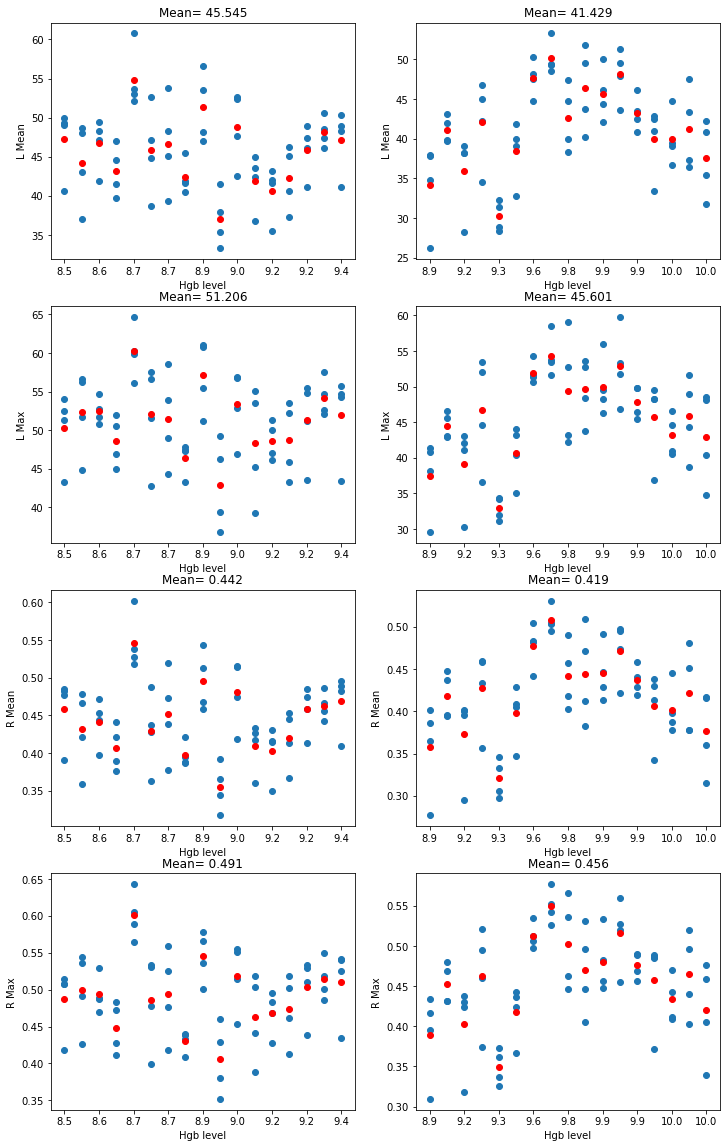

In [336]:
plot_methods(output_1, output_2, df_diagnosed, df_non_diag)

In [360]:
np.array(output_1)[0].mean(axis=1).shape

(17,)

In [363]:
p_values= np.ones((4,4))
for i_method, method in zip(range(4), ["L Mean", "L Max", "R Mean", "R Max"]):
    ave_1= np.array(output_1)[i_method].mean(axis=1)
    ave_2= np.array(output_2)[i_method].mean(axis=1)
    print(f"T-test p-value for {method}=", np.round(ttest_ind(ave_1, ave_2)[1],3))
    for i_nail in range(4):
        stat, pvalue= ttest_ind(np.array(output_1)[i_method,:,i_nail],np.array(output_2)[i_method,:,i_nail])
        p_values[i_method, i_nail]= pvalue
p_values_df= pd.DataFrame(p_values<0.05, index=["L Mean", "L Max", "R Mean", "R Max"], columns=["nail_1","nail_2","nail_3","nail_4"])
p_values_df

T-test p-value for L Mean= 0.017
T-test p-value for L Max= 0.002
T-test p-value for R Mean= 0.149
T-test p-value for R Max= 0.043


,nail_1,nail_2,nail_3,nail_4
L Mean,True,True,False,False
L Max,True,True,True,True
R Mean,False,False,False,False
R Max,True,False,False,False
